In [1]:
!pip install catboost --upgrade
!pip install lightgbm --install-option=--gpu --upgrade
!pip install statsmodels tqdm scikit-optimize --upgrade

Requirement already up-to-date: catboost in /usr/local/lib/python3.6/dist-packages (0.21)
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Requirement already up-to-date: lightgbm in /usr/local/lib/python3.6/dist-packages (2.3.1)
Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.11.0)
Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.42.1)
Requirement already up-to-date: scikit-optimize in /usr/local/lib/python3.6/dist-packages (0.7.2)


In [0]:
import os

from datetime import datetime, timedelta
from collections import defaultdict
from operator import itemgetter

import scipy.signal
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

import lightgbm as lgbm
from catboost import CatBoostRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [0]:
pd.set_option('display.max_columns', 100)

## Загрузка данных

In [4]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
WORKDIR = '/content/drive/My Drive/idao-2020/Track 1'

In [0]:
df_train = pd.read_csv(os.path.join(WORKDIR, "train_fixed.csv"), index_col="id", parse_dates=["epoch"])
df_test  = pd.read_csv(os.path.join(WORKDIR, "test_fixed.csv"), index_col="id", parse_dates=["epoch"])

In [7]:
df = pd.concat([df_train, df_test], sort=False)
df.sort_values(by=['sat_id', 'epoch'], inplace=True)
df.head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,x_predict,y_predict,z_predict,Vx_predict,Vy_predict,Vz_predict
id,,,,,,,,,,,,,,,,,,,,
0,2014-01-01 00:00:00.000000000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,-8843.131454,13112.940328,-20741.615306,-0.907527,-3.804930,-2.024133
1,2014-01-01 00:46:43.000000000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,-10555.500066,1614.764969,-24473.089556,-0.303704,-4.269816,-0.616468
2,2014-01-01 01:33:26.000999936,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,-10571.858472,-10185.695721,-24271.169776,0.274880,-4.046788,0.718768
3,2014-01-01 02:20:09.000999936,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,-9149.620794,-20656.825548,-20765.019094,0.712437,-3.375202,1.718306
4,2014-01-01 03:06:52.001999872,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,-6729.358857,-28934.560922,-14992.399986,0.989382,-2.522618,2.342237


In [8]:
COLS_TARGET = ['x', 'y', 'z', 'Vx', 'Vy', 'Vz']
COLS_TARGET_PREDICT = [col + '_predict' for col in COLS_TARGET]
COLS_TARGET_SIM = [col + '_sim' for col in COLS_TARGET]

ntop = 24 * 3

df_list = []
for name, group in tqdm(df.groupby('sat_id')):
    group_fix = group.iloc[:ntop]

    values_target = group_fix[COLS_TARGET].values
    values_predict = group_fix[COLS_TARGET_PREDICT].values
    values_sim = group_fix[COLS_TARGET_SIM].values
    
    error_predict = np.abs(values_target - values_predict)
    error_sim = np.abs(values_target - values_sim)
    group_fix[COLS_TARGET_PREDICT] = np.where(error_predict < error_sim, values_predict, values_sim)

    group.iloc[:ntop] = group_fix
    df_list.append(group)

df = pd.concat(df_list)
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,x_predict,y_predict,z_predict,Vx_predict,Vy_predict,Vz_predict
id,,,,,,,,,,,,,,,,,,,,
0,2014-01-01 00:00:00.000000000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,-8843.131454,13112.940328,-20741.615306,-0.907527,-3.804930,-2.024133
1,2014-01-01 00:46:43.000000000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,-10555.500066,1614.764969,-24473.089556,-0.303704,-4.269816,-0.616468
2,2014-01-01 01:33:26.000999936,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,-10571.858472,-10185.695721,-24271.169776,0.274880,-4.046788,0.718768
3,2014-01-01 02:20:09.000999936,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,-9149.620794,-20656.825548,-20765.019094,0.712437,-3.375202,1.718306
4,2014-01-01 03:06:52.001999872,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,-6729.358857,-28934.560922,-14992.399986,0.989382,-2.522618,2.342237


In [9]:
df.loc[:, COLS_TARGET_SIM] = df.loc[:, COLS_TARGET_PREDICT].values
df.drop(COLS_TARGET_PREDICT, axis=1, inplace=True)
df.head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,,,,,,,,,
0,2014-01-01 00:00:00.000000000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13112.940328,-20741.615306,-0.907527,-3.804930,-2.024133
1,2014-01-01 00:46:43.000000000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1614.764969,-24473.089556,-0.303704,-4.269816,-0.616468
2,2014-01-01 01:33:26.000999936,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10185.695721,-24271.169776,0.274880,-4.046788,0.718768
3,2014-01-01 02:20:09.000999936,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20656.825548,-20765.019094,0.712437,-3.375202,1.718306
4,2014-01-01 03:06:52.001999872,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28934.560922,-14992.399986,0.989382,-2.522618,2.342237


## Построение признаков

In [0]:
cols_vsim = ['Vx_sim', 'Vy_sim', 'Vz_sim']
cols_rsim = ['x_sim', 'y_sim', 'z_sim']

Время в секундах.

In [0]:
df['ts'] = df['epoch'].values.astype(np.int64) / 10 ** 9
df['ts_int'] = df['ts'].astype(int)

Нормы радиус-вектора и вектора скорости.

In [0]:
df['V_sim_norm'] = np.linalg.norm(df[cols_vsim], axis=1)
df['R_sim_norm'] = np.linalg.norm(df[cols_rsim], axis=1)

Сферические координаты радиус-вектора.

In [0]:
df['R_sim_theta'] = np.arccos(df['z_sim'] / df['R_sim_norm'])
df['R_sim_phi'] = np.arctan(df['y_sim'] / df['x_sim'])

Период обращения спутника.

In [14]:
def find_period(group):
    peaks_up, _ = scipy.signal.find_peaks(group['R_sim_norm'])
    peaks_up = peaks_up[1:-1]
    return np.diff(group['ts'].iloc[peaks_up]).mean()

df_aggs = df.groupby('sat_id')[['ts', 'R_sim_norm']].apply(find_period)
df_aggs = df_aggs.rename('ts_period').reset_index()
df_aggs.head()

,sat_id,ts_period
0,0,63822.165205
1,1,30164.174711
2,2,149564.963484
3,3,175133.397538
4,4,52141.690404


In [15]:
df = pd.merge(df, df_aggs, on='sat_id')
df.head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,ts,ts_int,V_sim_norm,R_sim_norm,R_sim_theta,R_sim_phi,ts_period
0,2014-01-01 00:00:00.000000000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13112.940328,-20741.615306,-0.907527,-3.804930,-2.024133,1.388534e+09,1388534400,4.404340,26083.803087,2.490119,-0.977471,63822.165205
1,2014-01-01 00:46:43.000000000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1614.764969,-24473.089556,-0.303704,-4.269816,-0.616468,1.388537e+09,1388537203,4.324766,26701.276374,2.730166,-0.151802,63822.165205
2,2014-01-01 01:33:26.000999936,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10185.695721,-24271.169776,0.274880,-4.046788,0.718768,1.388540e+09,1388540006,4.119305,28365.512002,2.597617,0.766797,63822.165205
3,2014-01-01 02:20:09.000999936,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20656.825548,-20765.019094,0.712437,-3.375202,1.718306,1.388543e+09,1388542809,3.853846,30685.599560,2.314071,1.153834,63822.165205
4,2014-01-01 03:06:52.001999872,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28934.560922,-14992.399986,0.989382,-2.522618,2.342237,1.388546e+09,1388545612,3.581697,33275.593815,2.038180,1.342287,63822.165205


Аггрегаты для нормы радиус-вектора и вектора скорости.

In [0]:
def flatten_columns(columns):
    columns = [ [level[i] for i in codes]
                for level, codes in zip(columns.levels, columns.codes) ]
    columns = ['_'.join(c) for c in zip(*columns)]
    return columns

In [17]:
df_aggs = df.groupby('sat_id')[['R_sim_norm', 'V_sim_norm']]\
            .agg([np.min, np.max, np.mean, np.std])
df_aggs.columns = flatten_columns(df_aggs.columns)
df_aggs.reset_index(inplace=True)

df_aggs['R_sim_norm_amplitude'] = (df_aggs['R_sim_norm_amax'] - df_aggs['R_sim_norm_amin']) / 2
df_aggs['V_sim_norm_amplitude'] = (df_aggs['V_sim_norm_amax'] - df_aggs['V_sim_norm_amin']) / 2

df_aggs.head()

,sat_id,R_sim_norm_amin,R_sim_norm_amax,R_sim_norm_mean,R_sim_norm_std,V_sim_norm_amin,V_sim_norm_amax,V_sim_norm_mean,V_sim_norm_std,R_sim_norm_amplitude,V_sim_norm_amplitude
0,0,23790.984277,45664.438814,37065.026107,6732.398419,2.376890,4.431642,3.272294,0.640291,10936.727269,1.027376
1,1,4245.015856,37467.011561,24896.058410,8169.057808,2.273087,8.074614,4.000338,1.691844,16610.997852,2.900764
2,2,35704.059361,89053.232011,67657.447558,17447.672953,1.537949,4.029323,2.404687,0.768744,26674.586325,1.245687
3,3,20850.153736,116118.919944,83710.881508,28009.496108,1.145502,5.012541,2.146529,1.064439,47634.383104,1.933519
4,4,20336.283333,40863.320896,32274.578580,6972.828479,2.489326,5.171737,3.504502,0.869232,10263.518781,1.341205


In [18]:
df = pd.merge(df, df_aggs, on='sat_id')
df.head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,ts,ts_int,V_sim_norm,R_sim_norm,R_sim_theta,R_sim_phi,ts_period,R_sim_norm_amin,R_sim_norm_amax,R_sim_norm_mean,R_sim_norm_std,V_sim_norm_amin,V_sim_norm_amax,V_sim_norm_mean,V_sim_norm_std,R_sim_norm_amplitude,V_sim_norm_amplitude
0,2014-01-01 00:00:00.000000000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13112.940328,-20741.615306,-0.907527,-3.804930,-2.024133,1.388534e+09,1388534400,4.404340,26083.803087,2.490119,-0.977471,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376
1,2014-01-01 00:46:43.000000000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1614.764969,-24473.089556,-0.303704,-4.269816,-0.616468,1.388537e+09,1388537203,4.324766,26701.276374,2.730166,-0.151802,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376
2,2014-01-01 01:33:26.000999936,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10185.695721,-24271.169776,0.274880,-4.046788,0.718768,1.388540e+09,1388540006,4.119305,28365.512002,2.597617,0.766797,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376
3,2014-01-01 02:20:09.000999936,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20656.825548,-20765.019094,0.712437,-3.375202,1.718306,1.388543e+09,1388542809,3.853846,30685.599560,2.314071,1.153834,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376
4,2014-01-01 03:06:52.001999872,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28934.560922,-14992.399986,0.989382,-2.522618,2.342237,1.388546e+09,1388545612,3.581697,33275.593815,2.038180,1.342287,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376


Проекции вектора скорости.

In [0]:
def projection_norm(radius, x):
    radius_unit = radius / np.linalg.norm(radius, axis=1)[:, np.newaxis]
    projection_norm = (x * radius_unit).sum(axis=1)
    return projection_norm

In [0]:
df['V_sim_projection_norm'] = projection_norm(
    df[['x_sim', 'y_sim', 'z_sim']].values,
    df[['Vx_sim', 'Vy_sim', 'Vz_sim']].values,
)

df['V_sim_projection_tang'] = \
    np.sqrt(df['V_sim_norm'] ** 2 - df['V_sim_projection_norm'] ** 2)

Градиенты для координат и скоростей.

In [0]:
def calculate_gradients(group, cols, h, depth=5):
    def calculate_gradients_level(group, cols_prev, cols_next, h):
        for col_prev, col_next in zip(cols_prev, cols_next):
            group[col_next] = np.gradient(group[col_prev], axis=0) / h
        return group
    
    for i in range(1, depth + 1):
        cols_prev = cols_next if i > 1 else cols
        cols_next = ['{}_tailor_{}'.format(c, i) for c in cols]
        group = calculate_gradients_level(group, cols_prev, cols_next, h)
    return group

In [22]:
df.sort_values(by=['sat_id', 'epoch'], inplace=True)

df_copy = df.drop_duplicates(subset=['sat_id', 'ts_int'])

df_list = []

for name, group in tqdm(df_copy.groupby('sat_id')):
    ts_delta_mean = group['ts'].diff().mean()
    
    group = calculate_gradients(
        group,
        ['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'],
        h=ts_delta_mean,
        depth=3,
    )

    group = group[['sat_id', 'ts_int'] + [c for c in group.columns if '_tailor_' in c]]
    df_list.append(group)
    
df_copy = pd.concat(df_list)
df = pd.merge(df, df_copy, on=['sat_id', 'ts_int'])
df.sort_values(by=['sat_id', 'epoch'], inplace=True)
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,ts,ts_int,V_sim_norm,R_sim_norm,R_sim_theta,R_sim_phi,ts_period,R_sim_norm_amin,R_sim_norm_amax,R_sim_norm_mean,R_sim_norm_std,V_sim_norm_amin,V_sim_norm_amax,V_sim_norm_mean,V_sim_norm_std,R_sim_norm_amplitude,V_sim_norm_amplitude,V_sim_projection_norm,V_sim_projection_tang,x_sim_tailor_1,y_sim_tailor_1,z_sim_tailor_1,Vx_sim_tailor_1,Vy_sim_tailor_1,Vz_sim_tailor_1,x_sim_tailor_2,y_sim_tailor_2,z_sim_tailor_2,Vx_sim_tailor_2,Vy_sim_tailor_2,Vz_sim_tailor_2,x_sim_tailor_3,y_sim_tailor_3,z_sim_tailor_3,Vx_sim_tailor_3,Vy_sim_tailor_3,Vz_sim_tailor_3
0,2014-01-01 00:00:00.000000000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13112.940328,-20741.615306,-0.907527,-3.804930,-2.024133,1.388534e+09,1388534400,4.404340,26083.803087,2.490119,-0.977471,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376,0.004423,4.404338,-0.610906,-4.102095,-1.331243,0.000215,-0.000166,0.000502,0.000108,-0.000019,0.000250,-1.606170e-09,4.377824e-08,-4.609251e-09,1.633087e-08,1.509050e-08,3.750947e-08,-1.600941e-12,5.091997e-12,-3.810844e-12
1,2014-01-01 00:46:43.000000000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1614.764969,-24473.089556,-0.303704,-4.269816,-0.616468,1.388537e+09,1388537203,4.324766,26701.276374,2.730166,-0.151802,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376,0.426867,4.303648,-0.308371,-4.156017,-0.629603,0.000211,-0.000043,0.000489,0.000154,0.000023,0.000355,-6.093608e-09,5.805111e-08,-1.529105e-08,1.236912e-08,2.925591e-08,2.804804e-08,-2.369308e-12,2.214752e-12,-5.531675e-12
2,2014-01-01 01:33:26.000999936,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10185.695721,-24271.169776,0.274880,-4.046788,0.718768,1.388540e+09,1388540006,4.119305,28365.512002,2.597617,0.766797,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376,0.735682,4.053079,0.250781,-3.972812,0.661447,0.000181,0.000160,0.000416,0.000177,0.000145,0.000408,-1.488851e-08,5.619414e-08,-3.561982e-08,-4.619457e-09,4.217846e-08,-1.155361e-08,-2.288615e-12,-5.671806e-12,-5.184457e-12
3,2014-01-01 02:20:09.000999936,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20656.825548,-20765.019094,0.712437,-3.375202,1.718306,1.388543e+09,1388542809,3.853846,30685.599560,2.314071,1.153834,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376,0.896896,3.748027,0.685426,-3.344428,1.655150,0.000127,0.000272,0.000290,0.000128,0.000260,0.000291,-1.892359e-08,2.625496e-08,-4.435512e-08,-1.786596e-08,2.769114e-08,-4.193425e-08,-3.100243e-13,-9.180059e-12,-5.312294e-13
4,2014-01-01 03:06:52.001999872,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28934.560922,-14992.399986,0.989382,-2.522618,2.342237,1.388546e+09,1388545612,3.581697,33275.593815,2.038180,1.342287,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376,0.938140,3.456653,0.967291,-2.517977,2.291038,0.000075,0.000307,0.000168,0.000077,0.000300,0.000172,-1.662651e-08,4.730725e-09,-3.859790e-08,-1.634966e-08,6.451189e-09,-3.799215e-08,1.133760e-12,-5.794915e-12,2.743349e-12


Ускорения и новые оценки ошибок.

```
x_new = x_old + v * d_t + a * d_t ^ 2 / 2
```

In [23]:
def calculate_diffs(group, cols, periods):
    for period in periods:
        cols_new = ['{}_diff_{}'.format(c, period) for c in cols]
        group[cols_new] = group[cols].diff(period)
    return group

cols_shift = ['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim',
              'V_sim_norm', 'R_sim_norm', 'R_sim_theta', 'R_sim_phi', 'ts']

df_list = []

for name, group in tqdm(df.groupby('sat_id')):
    group = calculate_diffs(group, cols=cols_shift, periods=range(1, 2))
    
    # acceleration, predicts and errors
    cols_from = ['Vx_sim_diff_1', 'Vy_sim_diff_1', 'Vz_sim_diff_1']
    cols_to = ['Ax_sim', 'Ay_sim', 'Az_sim']
    ts_delta = group['ts_diff_1'].values[:,np.newaxis]
    group[cols_to] = pd.DataFrame(group[cols_from].values / ts_delta)
    
    cols_asim = ['Ax_sim', 'Ay_sim', 'Az_sim']
    group_prev, group_curr = group, group.shift(-1)
    ts_delta = group_prev['ts_diff_1'].values[:,np.newaxis]
    
    coords_predict = group_prev[cols_rsim].values + \
                     ts_delta * group_prev[cols_vsim].values + \
                     0.5 * np.power(ts_delta, 2) * group_prev[cols_asim]
    coords_predict = pd.DataFrame(coords_predict)
    group_curr[['predict_x', 'predict_y', 'predict_z']] = coords_predict
    group_curr[['error_x', 'error_y', 'error_z']] = coords_predict - group_curr[cols_rsim].values
    
    verbocity_predict = group_prev[cols_vsim].values + ts_delta * group_prev[cols_asim]
    verbocity_predict = pd.DataFrame(verbocity_predict)
    group_curr[['predict_Vx', 'predict_Vy', 'predict_Vz']] = verbocity_predict
    group_curr[['error_Vx', 'error_Vy', 'error_Vz']] = verbocity_predict - group_curr[cols_vsim].values
    
    group = group_curr
    df_list.append(group)
    
df = pd.concat(df_list)
df.drop(columns=df.columns[df.columns.str.startswith('ts_diff_')], inplace=True)
df.dropna(axis=0, inplace=True, subset=['sat_id'])
df["sat_id"] = df["sat_id"].astype(int)
df.head(5)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,ts,ts_int,V_sim_norm,R_sim_norm,R_sim_theta,R_sim_phi,ts_period,R_sim_norm_amin,R_sim_norm_amax,R_sim_norm_mean,R_sim_norm_std,V_sim_norm_amin,V_sim_norm_amax,V_sim_norm_mean,V_sim_norm_std,R_sim_norm_amplitude,V_sim_norm_amplitude,V_sim_projection_norm,V_sim_projection_tang,x_sim_tailor_1,y_sim_tailor_1,z_sim_tailor_1,Vx_sim_tailor_1,Vy_sim_tailor_1,Vz_sim_tailor_1,x_sim_tailor_2,y_sim_tailor_2,z_sim_tailor_2,Vx_sim_tailor_2,Vy_sim_tailor_2,Vz_sim_tailor_2,x_sim_tailor_3,y_sim_tailor_3,z_sim_tailor_3,Vx_sim_tailor_3,Vy_sim_tailor_3,Vz_sim_tailor_3,x_sim_diff_1,y_sim_diff_1,z_sim_diff_1,Vx_sim_diff_1,Vy_sim_diff_1,Vz_sim_diff_1,V_sim_norm_diff_1,R_sim_norm_diff_1,R_sim_theta_diff_1,R_sim_phi_diff_1,Ax_sim,Ay_sim,Az_sim,predict_x,predict_y,predict_z,error_x,error_y,error_z,predict_Vx,predict_Vy,predict_Vz,error_Vx,error_Vy,error_Vz
0,2014-01-01 00:46:43.000000000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1614.764969,-24473.089556,-0.303704,-4.269816,-0.616468,1.388537e+09,1.388537e+09,4.324766,26701.276374,2.730166,-0.151802,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376,0.426867,4.303648,-0.308371,-4.156017,-0.629603,0.000211,-0.000043,0.000489,0.000154,0.000023,0.000355,-6.093608e-09,5.805111e-08,-1.529105e-08,1.236912e-08,2.925591e-08,2.804804e-08,-2.369308e-12,2.214752e-12,-5.531675e-12,-1712.368612,-11498.175360,-3731.474250,0.603823,-0.464886,1.407665,-0.079574,617.473287,0.240047,0.825670,0.000215,-0.000166,0.000502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-01 01:33:26.000999936,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10185.695721,-24271.169776,0.274880,-4.046788,0.718768,1.388540e+09,1.388540e+09,4.119305,28365.512002,2.597617,0.766797,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376,0.735682,4.053079,0.250781,-3.972812,0.661447,0.000181,0.000160,0.000416,0.000177,0.000145,0.000408,-1.488851e-08,5.619414e-08,-3.561982e-08,-4.619457e-09,4.217846e-08,-1.155361e-08,-2.288615e-12,-5.671806e-12,-5.184457e-12,-16.358406,-11800.460690,201.919781,0.578584,0.223028,1.335237,-0.205460,1664.235629,-0.132549,0.918598,0.000206,0.000080,0.000476,-10560.523879,-11005.067693,-24228.208240,11.334593,-819.371972,42.961536,0.300119,-4.734702,0.791196,0.025239,-0.687915,0.072428
2,2014-01-01 02:20:09.000999936,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20656.825548,-20765.019094,0.712437,-3.375202,1.718306,1.388543e+09,1.388543e+09,3.853846,30685.599560,2.314071,1.153834,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376,0.896896,3.748027,0.685426,-3.344428,1.655150,0.000127,0.000272,0.000290,0.000128,0.000260,0.000291,-1.892359e-08,2.625496e-08,-4.435512e-08,-1.786596e-08,2.769114e-08,-4.193425e-08,-3.100243e-13,-9.180059e-12,-5.312294e-13,1422.237678,-10471.129827,3506.150682,0.437556,0.671585,0.999537,-0.265459,2320.087558,-0.283546,0.387037,0.000156,0.000240,0.000357,-8990.482599,-21216.270885,-20385.125838,159.138195,-559.445337,379.893255,0.853464,-3.823759,2.054005,0.141028,-0.448557,0.335700
3,2014-01-01 03:06:52.001999872,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28934.560922,-14992.399986,0.989382,-2.522618,2.342237,1.388546e+09,1.388546e+09,3.581697,33275.593815,2.038180,1.342287,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376,0.938140,3.456653,0.967291,-2.517977,2.291038,0.000075,0.000307,0.000168,0.000077,0.000300,0.000172,-1.662651e-08,4.730725e-09,-3.859790e-08,-1.634966e-08,6.451189e-09,-3.799215e-08,1.133760e-12,-5.794915e-12,2.743349e-12,2420.261937,-8277.735374,5772.619108,0.276946,

Норма и проекции вектора ускорения.

In [0]:
df['A_sim_norm'] = np.linalg.norm(df[['Ax_sim', 'Ay_sim', 'Az_sim']], axis=1)

df['A_sim_projection_norm'] = projection_norm(
    df[['x_sim', 'y_sim', 'z_sim']].values,
    df[['Ax_sim', 'Ay_sim', 'Az_sim']].values,
)

df['A_sim_projection_tang'] = \
    np.sqrt(df['A_sim_norm'] ** 2 - df['A_sim_projection_norm'] ** 2)

In [25]:
df.head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,ts,ts_int,V_sim_norm,R_sim_norm,R_sim_theta,R_sim_phi,ts_period,R_sim_norm_amin,R_sim_norm_amax,R_sim_norm_mean,R_sim_norm_std,V_sim_norm_amin,V_sim_norm_amax,V_sim_norm_mean,V_sim_norm_std,R_sim_norm_amplitude,V_sim_norm_amplitude,V_sim_projection_norm,V_sim_projection_tang,x_sim_tailor_1,y_sim_tailor_1,z_sim_tailor_1,Vx_sim_tailor_1,Vy_sim_tailor_1,Vz_sim_tailor_1,x_sim_tailor_2,y_sim_tailor_2,z_sim_tailor_2,Vx_sim_tailor_2,Vy_sim_tailor_2,Vz_sim_tailor_2,x_sim_tailor_3,y_sim_tailor_3,z_sim_tailor_3,Vx_sim_tailor_3,Vy_sim_tailor_3,Vz_sim_tailor_3,x_sim_diff_1,y_sim_diff_1,z_sim_diff_1,Vx_sim_diff_1,Vy_sim_diff_1,Vz_sim_diff_1,V_sim_norm_diff_1,R_sim_norm_diff_1,R_sim_theta_diff_1,R_sim_phi_diff_1,Ax_sim,Ay_sim,Az_sim,predict_x,predict_y,predict_z,error_x,error_y,error_z,predict_Vx,predict_Vy,predict_Vz,error_Vx,error_Vy,error_Vz,A_sim_norm,A_sim_projection_norm,A_sim_projection_tang
0,2014-01-01 00:46:43.000000000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1614.764969,-24473.089556,-0.303704,-4.269816,-0.616468,1.388537e+09,1.388537e+09,4.324766,26701.276374,2.730166,-0.151802,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376,0.426867,4.303648,-0.308371,-4.156017,-0.629603,0.000211,-0.000043,0.000489,0.000154,0.000023,0.000355,-6.093608e-09,5.805111e-08,-1.529105e-08,1.236912e-08,2.925591e-08,2.804804e-08,-2.369308e-12,2.214752e-12,-5.531675e-12,-1712.368612,-11498.175360,-3731.474250,0.603823,-0.464886,1.407665,-0.079574,617.473287,0.240047,0.825670,0.000215,-0.000166,0.000502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000571,-0.000555,0.000133
1,2014-01-01 01:33:26.000999936,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10185.695721,-24271.169776,0.274880,-4.046788,0.718768,1.388540e+09,1.388540e+09,4.119305,28365.512002,2.597617,0.766797,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376,0.735682,4.053079,0.250781,-3.972812,0.661447,0.000181,0.000160,0.000416,0.000177,0.000145,0.000408,-1.488851e-08,5.619414e-08,-3.561982e-08,-4.619457e-09,4.217846e-08,-1.155361e-08,-2.288615e-12,-5.671806e-12,-5.184457e-12,-16.358406,-11800.460690,201.919781,0.578584,0.223028,1.335237,-0.205460,1664.235629,-0.132549,0.918598,0.000206,0.000080,0.000476,-10560.523879,-11005.067693,-24228.208240,11.334593,-819.371972,42.961536,0.300119,-4.734702,0.791196,0.025239,-0.687915,0.072428,0.000525,-0.000513,0.000112
2,2014-01-01 02:20:09.000999936,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20656.825548,-20765.019094,0.712437,-3.375202,1.718306,1.388543e+09,1.388543e+09,3.853846,30685.599560,2.314071,1.153834,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376,0.896896,3.748027,0.685426,-3.344428,1.655150,0.000127,0.000272,0.000290,0.000128,0.000260,0.000291,-1.892359e-08,2.625496e-08,-4.435512e-08,-1.786596e-08,2.769114e-08,-4.193425e-08,-3.100243e-13,-9.180059e-12,-5.312294e-13,1422.237678,-10471.129827,3506.150682,0.437556,0.671585,0.999537,-0.265459,2320.087558,-0.283546,0.387037,0.000156,0.000240,0.000357,-8990.482599,-21216.270885,-20385.125838,159.138195,-559.445337,379.893255,0.853464,-3.823759,2.054005,0.141028,-0.448557,0.335700,0.000457,-0.000449,0.000085
3,2014-01-01 03:06:52.001999872,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28934.560922,-14992.399986,0.989382,-2.522618,2.342237,1.388546e+09,1.388546e+09,3.581697,33275.593815,2.038180,1.342287,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376,0.938140,3.456653,0.967291,-2.517977,2.291038,0.000075,0.000307,0.000168,0.000077,0.000300,0.000172,-1.662651e-08,4.730725e-09,-3

In [26]:
df.shape

(933383, 79)

## Валидация

In [27]:
mask = df[COLS_TARGET].isna().any(axis=1)
df_train, df_test = df[~mask], df[mask]
df_test.drop(columns=COLS_TARGET, inplace=True)
df_train.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,ts,ts_int,V_sim_norm,R_sim_norm,R_sim_theta,R_sim_phi,ts_period,R_sim_norm_amin,R_sim_norm_amax,R_sim_norm_mean,R_sim_norm_std,V_sim_norm_amin,V_sim_norm_amax,V_sim_norm_mean,V_sim_norm_std,R_sim_norm_amplitude,V_sim_norm_amplitude,V_sim_projection_norm,V_sim_projection_tang,x_sim_tailor_1,y_sim_tailor_1,z_sim_tailor_1,Vx_sim_tailor_1,Vy_sim_tailor_1,Vz_sim_tailor_1,x_sim_tailor_2,y_sim_tailor_2,z_sim_tailor_2,Vx_sim_tailor_2,Vy_sim_tailor_2,Vz_sim_tailor_2,x_sim_tailor_3,y_sim_tailor_3,z_sim_tailor_3,Vx_sim_tailor_3,Vy_sim_tailor_3,Vz_sim_tailor_3,x_sim_diff_1,y_sim_diff_1,z_sim_diff_1,Vx_sim_diff_1,Vy_sim_diff_1,Vz_sim_diff_1,V_sim_norm_diff_1,R_sim_norm_diff_1,R_sim_theta_diff_1,R_sim_phi_diff_1,Ax_sim,Ay_sim,Az_sim,predict_x,predict_y,predict_z,error_x,error_y,error_z,predict_Vx,predict_Vy,predict_Vz,error_Vx,error_Vy,error_Vz,A_sim_norm,A_sim_projection_norm,A_sim_projection_tang
0,2014-01-01 00:46:43.000000000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1614.764969,-24473.089556,-0.303704,-4.269816,-0.616468,1.388537e+09,1.388537e+09,4.324766,26701.276374,2.730166,-0.151802,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376,0.426867,4.303648,-0.308371,-4.156017,-0.629603,0.000211,-0.000043,0.000489,0.000154,0.000023,0.000355,-6.093608e-09,5.805111e-08,-1.529105e-08,1.236912e-08,2.925591e-08,2.804804e-08,-2.369308e-12,2.214752e-12,-5.531675e-12,-1712.368612,-11498.175360,-3731.474250,0.603823,-0.464886,1.407665,-0.079574,617.473287,0.240047,0.825670,0.000215,-0.000166,0.000502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000571,-0.000555,0.000133
1,2014-01-01 01:33:26.000999936,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10185.695721,-24271.169776,0.274880,-4.046788,0.718768,1.388540e+09,1.388540e+09,4.119305,28365.512002,2.597617,0.766797,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376,0.735682,4.053079,0.250781,-3.972812,0.661447,0.000181,0.000160,0.000416,0.000177,0.000145,0.000408,-1.488851e-08,5.619414e-08,-3.561982e-08,-4.619457e-09,4.217846e-08,-1.155361e-08,-2.288615e-12,-5.671806e-12,-5.184457e-12,-16.358406,-11800.460690,201.919781,0.578584,0.223028,1.335237,-0.205460,1664.235629,-0.132549,0.918598,0.000206,0.000080,0.000476,-10560.523879,-11005.067693,-24228.208240,11.334593,-819.371972,42.961536,0.300119,-4.734702,0.791196,0.025239,-0.687915,0.072428,0.000525,-0.000513,0.000112
2,2014-01-01 02:20:09.000999936,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20656.825548,-20765.019094,0.712437,-3.375202,1.718306,1.388543e+09,1.388543e+09,3.853846,30685.599560,2.314071,1.153834,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376,0.896896,3.748027,0.685426,-3.344428,1.655150,0.000127,0.000272,0.000290,0.000128,0.000260,0.000291,-1.892359e-08,2.625496e-08,-4.435512e-08,-1.786596e-08,2.769114e-08,-4.193425e-08,-3.100243e-13,-9.180059e-12,-5.312294e-13,1422.237678,-10471.129827,3506.150682,0.437556,0.671585,0.999537,-0.265459,2320.087558,-0.283546,0.387037,0.000156,0.000240,0.000357,-8990.482599,-21216.270885,-20385.125838,159.138195,-559.445337,379.893255,0.853464,-3.823759,2.054005,0.141028,-0.448557,0.335700,0.000457,-0.000449,0.000085
3,2014-01-01 03:06:52.001999872,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28934.560922,-14992.399986,0.989382,-2.522618,2.342237,1.388546e+09,1.388546e+09,3.581697,33275.593815,2.038180,1.342287,63822.165205,23790.984277,45664.438814,37065.026107,6732.398419,2.37689,4.431642,3.272294,0.640291,10936.727269,1.027376,0.938140,3.456653,0.967291,-2.517977,2.291038,0.000075,0.000307,0.000168,0.000077,0.000300,0.000172,-1.662651e-08,4.730725e-09,-3

In [28]:
df_train.shape, df_test.shape

((649312, 79), (284071, 73))

In [29]:
cols_target = COLS_TARGET
cols_features = df.columns[~df.columns.isin(cols_target)]
cols_features = cols_features.drop(['epoch', 'ts', 'ts_int'])
cols_features = cols_features.to_list()
# cols_features.remove('sat_id')
cols_features

['sat_id',
 'x_sim',
 'y_sim',
 'z_sim',
 'Vx_sim',
 'Vy_sim',
 'Vz_sim',
 'V_sim_norm',
 'R_sim_norm',
 'R_sim_theta',
 'R_sim_phi',
 'ts_period',
 'R_sim_norm_amin',
 'R_sim_norm_amax',
 'R_sim_norm_mean',
 'R_sim_norm_std',
 'V_sim_norm_amin',
 'V_sim_norm_amax',
 'V_sim_norm_mean',
 'V_sim_norm_std',
 'R_sim_norm_amplitude',
 'V_sim_norm_amplitude',
 'V_sim_projection_norm',
 'V_sim_projection_tang',
 'x_sim_tailor_1',
 'y_sim_tailor_1',
 'z_sim_tailor_1',
 'Vx_sim_tailor_1',
 'Vy_sim_tailor_1',
 'Vz_sim_tailor_1',
 'x_sim_tailor_2',
 'y_sim_tailor_2',
 'z_sim_tailor_2',
 'Vx_sim_tailor_2',
 'Vy_sim_tailor_2',
 'Vz_sim_tailor_2',
 'x_sim_tailor_3',
 'y_sim_tailor_3',
 'z_sim_tailor_3',
 'Vx_sim_tailor_3',
 'Vy_sim_tailor_3',
 'Vz_sim_tailor_3',
 'x_sim_diff_1',
 'y_sim_diff_1',
 'z_sim_diff_1',
 'Vx_sim_diff_1',
 'Vy_sim_diff_1',
 'Vz_sim_diff_1',
 'V_sim_norm_diff_1',
 'R_sim_norm_diff_1',
 'R_sim_theta_diff_1',
 'R_sim_phi_diff_1',
 'Ax_sim',
 'Ay_sim',
 'Az_sim',
 'predict_x',
 

In [0]:
def smape(satellite_predicted_values, satellite_true_values): 
    # the division, addition and subtraction are pointwise 
    return np.mean(np.abs((satellite_predicted_values - satellite_true_values) 
        / (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))

In [0]:
def smape_lgbm(y_true, y_pred):
    return 'SMAPE', 100 * (1 - smape(y_pred, y_true)), True

CV по sat_id

In [0]:
use_modified_target = True
use_sample_weight = False

In [0]:
sat_weights = df_train.groupby('sat_id')['epoch'].agg('count').rename('weight')
sat_weights = 1 / sat_weights
sat_weights = sat_weights.reset_index()
sat_weights.head()

In [0]:
kfold = KFold(n_splits=5, random_state=9872)
seeds = np.random.RandomState(9856).randint(1000, 10000, kfold.n_splits)
 
sat_id_uniq = df_train['sat_id'].unique()
 
models = []
scores = []
 
splits = kfold.split(sat_id_uniq)
splits = zip(seeds, splits)
 
for seed, (ids_train, ids_valid) in tqdm(splits, total=kfold.n_splits):
    index_train = df_train['sat_id'].isin(ids_train)
    index_valid = df_train['sat_id'].isin(ids_valid)
   
    X_train, y_train = df_train.loc[index_train, cols_features], df_train.loc[index_train, cols_target]
    X_valid, y_valid = df_train.loc[index_valid, cols_features], df_train.loc[index_valid, cols_target]

    if use_sample_weight:
        sample_weight = pd.merge(df_train.loc[index_train, ['sat_id']], sat_weights, on='sat_id')['weight']
    else:
        sample_weight = None
   
    models_fold = {}
    y_pred_fold = []
    y_true_fold = []
   
    for target in tqdm(cols_target, leave=False):
        if use_modified_target:
            y_train_mod = y_train[target] - X_train[target + '_sim']
            y_valid_mod = y_valid[target] - X_valid[target + '_sim']
        else:
            y_train_mod = y_train[target]
            y_valid_mod = y_valid[target]

        '''
        cl = CatBoostRegressor(iterations=2000, max_depth=8, learning_rate=0.3,
                               eval_metric='SMAPE', task_type='GPU', thread_count=16,
                               verbose=False, random_state=seed)
        cl = cl.fit(X_train, y_train_mod, sample_weight=sample_weight, verbose=False,
                    eval_set=[(X_valid, y_valid_mod)], ignored_features=['sat_id'])
        '''

        ('sat_id' in X_train.columns) and X_train.drop(['sat_id'], axis=1, inplace=True)
        ('sat_id' in X_test.columns)  and X_test.drop(['sat_id'], axis=1, inplace=True)

        cl = lgbm.LGBMRegressor(boosting_type='gbdt', objective='regression', num_leaves=1200,
                                learning_rate=0.17, n_estimators=200, metric='mape',
                                bagging_fraction=0.8, feature_fraction=0.8, reg_lambda=0.9)
        cl = cl.fit(X_train, y_train_mod, sample_weight=sample_weight, verbose=False,
                    eval_set=[(X_valid, y_valid_mod)], eval_metric=smape_lgbm)
 
        y_pred_mod = cl.predict(X_valid)
        if use_modified_target:
            y_pred = y_pred_mod + X_valid[target + '_sim']
        else:
            y_pred = y_pred_mod

        y_pred_fold.append(y_pred)
        y_true_fold.append(y_valid[target])
        models_fold[target] = cl
       
    models.append(models_fold)
   
    y_pred = np.vstack(y_pred_fold)
    y_true = np.vstack(y_true_fold)
   
    score = 100 * (1 - smape(y_pred, y_true))
    scores.append(score)
    print(score)
       
len(scores), len(models)

In [0]:
np.mean(scores)

In [0]:
best_iteration = defaultdict(list)

for m_list in models:
    for k, v in m_list.items():
        best_iteration[k].append(v.best_iteration_)
        
for k, v in best_iteration.items():
    print(k, v, np.mean(v), sep='\t')

In [0]:
feature_importance = pd.Series(np.mean([i['x'].feature_importances_ for i in models], axis=0), X_train.columns)
feature_importance = sorted(feature_importance.to_dict().items(), key=itemgetter(1), reverse=True)

for v in feature_importance:
    print('{:25s}\t{:10.6f}'.format(*v))

In [0]:
lgbm.plot_metric(models[1]['Vx'].evals_result_, metric='SMAPE')

CV (наивный вариант)

In [0]:
use_modified_target = True
use_sample_weight = False

In [33]:
sat_weights = df_train.groupby('sat_id')['epoch'].agg('count').rename('weight')
sat_weights = 1 / sat_weights
sat_weights = sat_weights.reset_index()
sat_weights.head()

,sat_id,weight
0,0,0.001045
1,1,0.000475
2,2,0.002404
3,3,0.002833
4,4,0.000827


In [34]:
seeds = np.random.RandomState(9856).randint(1000, 10000, 5)

models = []
scores = []
  
for seed in tqdm(seeds):
    X_train, X_valid, y_train, y_valid, sample_weight, _ = train_test_split(
        df_train.loc[:, cols_features],
        df_train.loc[:, cols_target],
        pd.merge(df_train.loc[:, ['sat_id']], sat_weights, on='sat_id')['weight'],
        test_size=0.25,
        random_state=seed,
        stratify=df_train.loc[:, 'sat_id'],
    )

    if not use_sample_weight:
        sample_weight = None

    models_fold = {}
    y_pred_fold = []
    y_true_fold = []

    for target in tqdm(cols_target, leave=False):
        if use_modified_target:
            y_train_mod = y_train[target] - X_train[target + '_sim']
            y_valid_mod = y_valid[target] - X_valid[target + '_sim']
        else:
            y_train_mod = y_train[target]
            y_valid_mod = y_valid[target]
        
        '''
        cl = CatBoostRegressor(iterations=2000, max_depth=8, learning_rate=0.3,
                               eval_metric='SMAPE', task_type='GPU', thread_count=16,
                               verbose=False, random_state=seed)
        cl = cl.fit(X_train, y_train_mod, sample_weight=sample_weight, verbose=False,
                    eval_set=[(X_valid, y_valid_mod)], cat_features=['sat_id'])
        '''

        cl = lgbm.LGBMRegressor(boosting_type='gbdt', objective='regression', num_leaves=1200,
                                learning_rate=0.17, n_estimators=200, metric='mape',
                                bagging_fraction=0.8, feature_fraction=0.8, reg_lambda=0.9)
        cl = cl.fit(X_train, y_train_mod, sample_weight=sample_weight, verbose=False, 
                    eval_set=[(X_valid, y_valid_mod)], eval_metric=smape_lgbm)
 
        y_pred_mod = cl.predict(X_valid)
        if use_modified_target:
            y_pred = y_pred_mod + X_valid[target + '_sim']
        else:
            y_pred = y_pred_mod

        y_pred_fold.append(y_pred)
        y_true_fold.append(y_valid[target])
        models_fold[target] = cl
       
    models.append(models_fold)
   
    y_pred = np.vstack(y_pred_fold)
    y_true = np.vstack(y_true_fold)
   
    score = 100 * (1 - smape(y_pred, y_true))
    scores.append(score)
    print(score)
       
len(scores), len(models)

99.63951439334042


99.63722946747754


99.63784035105806


99.6388512414485


99.64456400264852



(5, 5)

In [35]:
np.mean(scores)

99.63959989119459

In [0]:
best_iteration = defaultdict(list)

for m_list in models:
    for k, v in m_list.items():
        best_iteration[k].append(v.best_iteration_)
        
for k, v in best_iteration.items():
    print(k, v, np.mean(v), sep='\t')

In [36]:
feature_importance = pd.Series(np.mean([i['x'].feature_importances_ for i in models], axis=0), X_train.columns)
feature_importance = sorted(feature_importance.to_dict().items(), key=itemgetter(1), reverse=True)

for v in feature_importance:
    print('{:25s}\t{:10.6f}'.format(*v))

V_sim_projection_norm    	12024.800000
V_sim_norm_diff_1        	8994.600000
x_sim                    	8967.800000
R_sim_norm_diff_1        	8763.800000
R_sim_phi                	8641.200000
R_sim_phi_diff_1         	7857.000000
R_sim_theta_diff_1       	7702.600000
R_sim_norm               	6725.600000
Vx_sim                   	6597.800000
x_sim_diff_1             	6521.600000
Vx_sim_diff_1            	6326.600000
V_sim_projection_tang    	6264.600000
x_sim_tailor_1           	6208.200000
y_sim                    	5713.600000
y_sim_diff_1             	5696.400000
x_sim_tailor_2           	5686.600000
R_sim_theta              	5662.400000
z_sim                    	5598.000000
x_sim_tailor_3           	5533.200000
V_sim_norm               	5483.800000
Vz_sim_diff_1            	5322.400000
z_sim_diff_1             	5283.400000
Vz_sim                   	5125.400000
Vy_sim_diff_1            	4896.200000
Vy_sim                   	4538.800000
Vx_sim_tailor_3          	4229.200000
y_sim_tailo

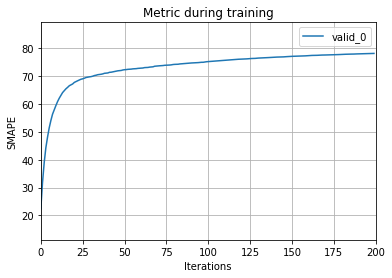

In [39]:
lgbm.plot_metric(models[0]['Vx'].evals_result_, metric='SMAPE')

CV (timeline)

In [0]:
use_modified_target = True
use_sample_weight = False

In [0]:
sat_weights = df_train.groupby('sat_id')['epoch'].agg('count').rename('weight')
sat_weights = 1 / sat_weights
sat_weights = sat_weights.reset_index()
sat_weights.head()

In [0]:
epoch_threshold = df_train.groupby('sat_id')['epoch'].max().min() - timedelta(days=7)
mask_train = df_train['epoch'] < epoch_threshold
mask_valid = ~mask_train & df_train['sat_id'].isin(df_test['sat_id'].unique())

print(mask_train.sum() / (mask_train.sum() + mask_valid.sum()))

X_train, X_valid = df_train.loc[mask_train, cols_features], df_train.loc[mask_valid, cols_features]
y_train, y_valid = df_train.loc[mask_train, cols_target],   df_train.loc[mask_valid, cols_target]

if use_sample_weight:
    sample_weight = pd.merge(df_train.loc[index_train, ['sat_id']], sat_weights, on='sat_id')['weight']
else:
    sample_weight = None

models_fold = {}
y_pred_fold = []
y_true_fold = []

for target in tqdm(cols_target, leave=True):
    if use_modified_target:
        y_train_mod = y_train[target] - X_train[target + '_sim']
        y_valid_mod = y_valid[target] - X_valid[target + '_sim']
    else:
        y_train_mod = y_train[target]
        y_valid_mod = y_valid[target]
    
    '''
    cl = CatBoostRegressor(iterations=2000, max_depth=8, learning_rate=0.3,
                            eval_metric='SMAPE', task_type='GPU', thread_count=16,
                            verbose=False, random_state=seed)
    cl = cl.fit(X_train, y_train_mod, sample_weight=sample_weight, verbose=False,
                eval_set=[(X_valid, y_valid_mod)], cat_features=['sat_id'])
    '''

    cl = lgbm.LGBMRegressor(boosting_type='gbdt', objective='regression', num_leaves=1200,
                            learning_rate=0.17, n_estimators=200, metric='mape',
                            bagging_fraction=0.8, feature_fraction=0.8, reg_lambda=0.9)
    cl = cl.fit(X_train, y_train_mod, sample_weight=sample_weight, verbose=False,
                eval_set=[(X_valid, y_valid_mod)], eval_metric=smape_lgbm)

    y_pred_mod = cl.predict(X_valid)
    if use_modified_target:
        y_pred = y_pred_mod + X_valid[target + '_sim']
    else:
        y_pred = y_pred_mod

    y_pred_fold.append(y_pred)
    y_true_fold.append(y_valid[target])
    models_fold[target] = cl
    
models = models_fold

y_pred = np.vstack(y_pred_fold)
y_true = np.vstack(y_true_fold)

score = 100 * (1 - smape(y_pred, y_true))
score

In [0]:
feature_importance = pd.Series(models['x'].feature_importances_, index=X_train.columns)
feature_importance = sorted(feature_importance.to_dict().items(), key=itemgetter(1), reverse=True)

for v in feature_importance:
    print('{:25s}\t{:10.6f}'.format(*v))

In [0]:
lgbm.plot_metric(models['Vx'].evals_result_, metric='SMAPE')

Submission

In [0]:
# aggregate_func = np.mean
aggregate_func = np.median

In [41]:
submit = pd.read_csv(os.path.join(WORKDIR, "submission.csv"), index_col="id")
 
for target in tqdm(COLS_TARGET):
    y_pred_all = []
    for model_i in tqdm(range(len(models)), leave=False):
        y_pred = models[model_i][target].predict(df_test[cols_features])
        y_pred = y_pred.reshape(-1, 1)
        y_pred_all.append(y_pred)
    y_pred = np.concatenate(y_pred_all, axis=1)
    y_pred = aggregate_func(y_pred, axis=1)
    if use_modified_target:
        y_pred = y_pred + df_test[target + '_sim'].values
    submit[target] = y_pred

In [42]:
submit.to_csv(os.path.join(WORKDIR, "cv_31_models.csv"), header=True, index=True)
submit.head()

,x,y,z,Vx,Vy,Vz
id,,,,,,
3927,-24786.357431,-10910.517211,6571.801510,2.614324,-1.303675,1.087172
3928,-21087.912794,-12377.912131,7837.154041,3.219273,-0.994320,0.896860
3929,-16577.651253,-13378.049984,8802.720142,3.880369,-0.538490,0.600836
3930,-11194.404525,-13671.764382,9302.107587,4.584401,0.159225,0.134534
3931,-4915.855950,-12806.104796,9006.751445,5.255626,1.295757,-0.653796
